# Translational mapping

In this notebook we explicitely model the link between the regulatory and structural embeddings of the U2OS cells and evaluate their generalizability.

---


## 0. Enviromental setup

We first load the required packages and define a number of helper functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    GroupShuffleSplit,
    LeaveOneGroupOut,
)
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import copy
from sklearn.neighbors import NearestNeighbors
from collections import Counter


seed = 1234

device = "cpu"

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def train_model(
    model,
    optimizer,
    criterion,
    data_dict,
    n_epochs=1000,
    early_stopping=50,
    device="cpu",
):

    best_val_loss = np.infty
    best_epoch = 0
    best_model_weights = None
    es_counter = 0

    for i in range(n_epochs):
        if es_counter > early_stopping:
            break
        for mode in ["train", "val"]:
            loss = process_single_epoch(
                model=model,
                optimizer=optimizer,
                criterion=criterion,
                data=data_dict[mode],
                mode=mode,
            )
            # print("{} loss: {}".format(mode.upper(), loss))

            if mode == "val":
                if loss < best_val_loss:
                    best_val_loss = loss
                    best_epoch = i
                    best_model_weights = copy.deepcopy(model.state_dict())
                else:
                    es_counter += 1

    model.load_state_dict(best_model_weights)

    for mode in ["train", "val", "test"]:
        loss = process_single_epoch(
            model, optimizer, criterion, data_dict[mode], "test"
        )
        print("{} loss: {}".format(mode.upper(), loss))

    return model


def process_single_epoch(model, optimizer, criterion, data, mode, device="cpu"):
    total_loss = 0
    model.to(device)
    if mode == "train":
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    for inputs, labels, _ in data:
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(mode == "train"):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * outputs.size(0)

            # backward + optimize only if in training phase
        if mode == "train":
            loss.backward()
            optimizer.step()

    total_loss /= len(data.dataset)
    return total_loss

<IPython.core.display.Javascript object>

In [3]:
class IndexedTensorDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, groups):
        super().__init__()
        self.data = data
        self.labels = labels
        self.groups = groups

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.groups[idx]

    def __len__(self):
        return len(self.groups)

<IPython.core.display.Javascript object>

In [4]:
def get_data_dict(
    data,
    labels,
    val_test_size=[0.2, 0.2],
    batch_size=32,
    group_labels=None,
    scale_x=True,
    scale_y=False,
    random_state=1234,
):

    idc = list(range(len(data)))
    if group_labels is None:
        train_val_idc, test_idc = train_test_split(
            idc, test_size=val_test_size[1], random_state=seed
        )
        train_idc, val_idc = train_test_split(
            train_val_idc, test_size=(val_test_size[0] / (1 - val_test_size[1]))
        )
    else:
        gss = GroupShuffleSplit(
            n_splits=2, test_size=val_test_size[1], random_state=random_state
        )
        train_val_idc, test_idc = next(gss.split(idc, groups=group_labels))
        gss = GroupShuffleSplit(
            n_splits=2,
            test_size=(val_test_size[0] / (1 - val_test_size[1])),
            random_state=seed,
        )
        train_idc, val_idc = next(
            gss.split(train_val_idc, groups=group_labels[train_val_idc])
        )

    train_data, train_labels = data.iloc[train_idc], labels.iloc[train_idc]
    val_data, val_labels = data.iloc[val_idc], labels.iloc[val_idc]
    test_data, test_labels = data.iloc[test_idc], labels.iloc[test_idc]

    if scale_x:
        sc = StandardScaler().fit(train_data)
        train_data = sc.transform(train_data)
        val_data = sc.transform(val_data)
        test_data = sc.transform(test_data)

    if scale_y:
        sc = StandardScaler().fit(train_labels)
        train_labels = sc.transform(train_labels)
        val_labels = sc.transform(val_labels)
        test_labels = sc.transform(test_labels)

    train_dataset = IndexedTensorDataset(
        torch.FloatTensor(np.array(train_data)),
        torch.FloatTensor(np.array(train_labels)),
        list(labels.iloc[train_idc].index),
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = IndexedTensorDataset(
        torch.FloatTensor(np.array(val_data)),
        torch.FloatTensor(np.array(val_labels)),
        list(labels.iloc[val_idc].index),
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = IndexedTensorDataset(
        torch.FloatTensor(np.array(test_data)),
        torch.FloatTensor(np.array(test_labels)),
        list(labels.iloc[test_idc].index),
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return {"train": train_loader, "val": val_loader, "test": test_loader}

<IPython.core.display.Javascript object>

In [5]:
def evaluate_top_k_accuracy(preds, labels, node_embs, k=5, random_state=1234):
    np.random.seed(random_state)
    k_correct = 0
    k_baseline_correct = 0
    neigh = NearestNeighbors(n_neighbors=k, p=2)
    targets = np.array(node_embs.index)
    counts = Counter(labels)
    most_common = list(sorted(counts, key=counts.get, reverse=True))
    # print(most_common)
    fitted_neigh = neigh.fit(np.array(node_embs))

    neighbor_preds = fitted_neigh.kneighbors(preds, k, return_distance=False)
    for i in range(len(neighbor_preds)):
        if labels[i] in targets[neighbor_preds[i]]:
            k_correct += 1
        if labels[i] in np.random.choice(targets, size=k):
            k_baseline_correct += 1
    return k_correct / len(labels), k_baseline_correct / len(labels)

<IPython.core.display.Javascript object>

In [6]:
def get_preds_label_dict(model, data):
    preds = []
    labels = []

    model.eval()

    for batch_inputs, _, batch_labels in data:
        batch_preds = model(batch_inputs)
        preds.extend(list(batch_preds.clone().detach().numpy()))
        labels.extend(list(batch_labels))
    return np.array(preds), np.array(labels)

<IPython.core.display.Javascript object>

In [21]:
def get_logo_data_dicts(
    data,
    labels,
    group_labels,
    val_size=0.1,
    batch_size=128,
    random_state=1234,
    scale_x=True,
    scale_y=False,
):
    logo = LeaveOneGroupOut()
    data_dicts = []
    idc = list(range(len(labels)))
    for train_val_idc, test_idc in logo.split(idc, groups=group_labels):
        gss = gss = GroupShuffleSplit(
            n_splits=2, test_size=val_size, random_state=random_state
        )
        train_idc, val_idc = next(
            gss.split(train_val_idc, groups=group_labels[train_val_idc])
        )

        train_data, train_labels = data.iloc[train_idc], labels.iloc[train_idc]
        val_data, val_labels = data.iloc[val_idc], labels.iloc[val_idc]
        test_data, test_labels = data.iloc[test_idc], labels.iloc[test_idc]

        if scale_x:
            sc = StandardScaler().fit(train_data)
            train_data = sc.transform(train_data)
            val_data = sc.transform(val_data)
            test_data = sc.transform(test_data)

        if scale_y:
            sc = StandardScaler().fit(train_labels)
            train_labels = sc.transform(train_labels)
            val_labels = sc.transform(val_labels)
            test_labels = sc.transform(test_labels)

        train_dataset = IndexedTensorDataset(
            torch.FloatTensor(np.array(train_data)),
            torch.FloatTensor(np.array(train_labels)),
            list(labels.iloc[train_idc].index),
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = IndexedTensorDataset(
            torch.FloatTensor(np.array(val_data)),
            torch.FloatTensor(np.array(val_labels)),
            list(labels.iloc[val_idc].index),
        )
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        test_dataset = IndexedTensorDataset(
            torch.FloatTensor(np.array(test_data)),
            torch.FloatTensor(np.array(test_labels)),
            list(labels.iloc[test_idc].index),
        )
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        data_dict = {"train": train_loader, "val": val_loader, "test": test_loader}
        data_dicts.append(data_dict)
    return data_dicts

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we read in the different data sets that we will use for the modelling and evaluation of the translational mappings. The first data set includes all structural embeddings from data held-out during training as well as the regulatory embeddings of the 244 genes that are part of the inferred interactome.

In [7]:
node_embs = pd.read_csv(
    "../../../data/ppi/embedding/node_embeddings_cv.csv", index_col=0
)
node_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
CDCA2,-0.046519,-0.049060,-0.065633,0.102739,-0.037012,0.067560,0.070266,-0.008673,0.128273,0.004020,...,-0.071056,-0.156410,0.006000,0.093432,0.034559,0.010527,-0.045864,0.068302,0.115374,-0.101571
APPBP2,-0.093607,-0.018010,0.060400,-0.022461,0.071339,0.044652,-0.002030,0.008269,-0.100545,-0.035760,...,-0.100010,0.168263,-0.103005,-0.055163,0.053544,-0.075707,0.119875,0.000469,0.004186,0.123274
TK1,0.023958,0.160870,-0.038898,-0.067761,-0.060810,-0.001184,0.000734,0.029148,0.024501,-0.096013,...,0.057610,-0.050949,-0.017972,0.008282,-0.003922,-0.061075,0.055963,0.034356,0.079510,-0.078223
MMP2,-0.036499,-0.147354,0.082521,0.133464,0.180986,-0.040401,0.066718,-0.040661,-0.171430,0.154789,...,-0.090356,0.352892,0.012735,-0.153441,-0.086582,0.092603,0.052464,0.000355,-0.323068,0.277830
PRKACA,0.021894,0.071289,0.021641,-0.079990,0.044919,-0.082366,0.013962,-0.063172,-0.081244,-0.032706,...,0.062312,0.063952,-0.050152,0.112115,-0.041111,0.073021,0.032152,-0.068759,-0.117734,0.067075


<IPython.core.display.Javascript object>

After having loaded the regulatory embeddings, we will now load the structural embeddings defined by the embeddings of the images held-out during the different folds of the cross-validation. Note that we do not group the data of the individual folds as the inferred models map to different latent spaces. We will also decode the numerical labels.

In [8]:
label_dict = {
    "AKT1S1": 0,
    "APC": 1,
    "ATF4": 2,
    "BAX": 3,
    "BCL2L11": 4,
    "BRAF": 5,
    "CASP8": 6,
    "CDC42": 7,
    "CDKN1A": 8,
    "CEBPA": 9,
    "CREB1": 10,
    "CSNK1E": 11,
    "CXXC4": 12,
    "DIABLO": 13,
    "E2F1": 14,
    "ELK1": 15,
    "EMPTY": 16,
    "ERG": 17,
    "FGFR3": 18,
    "FOXO1": 19,
    "GLI1": 20,
    "HRAS": 21,
    "IRAK4": 22,
    "JUN": 23,
    "KRAS": 24,
    "MAP2K3": 25,
    "MAP3K2": 26,
    "MAP3K5": 27,
    "MAP3K9": 28,
    "MAPK7": 29,
    "MOS": 30,
    "MYD88": 31,
    "PIK3R2": 32,
    "PKIA": 33,
    "PRKACA": 34,
    "PRKCE": 35,
    "RAF1": 36,
    "RELB": 37,
    "RHOA": 38,
    "SMAD3": 39,
    "SMAD4": 40,
    "SMO": 41,
    "SRC": 42,
    "SREBF1": 43,
    "TRAF2": 44,
    "TSC2": 45,
    "WWTR1": 46,
}

label_dict = {v: k for k, v in label_dict.items()}


img_embs_dict = {}
for i in range(4):
    img_embs = pd.read_hdf(
        "../../../data/experiments/image_embeddings/specificity_target_emb_cv_strat/final_1024/fold_{}/test_latents.h5".format(
            i
        )
    )
    img_embs.iloc[:, -1] = img_embs.iloc[:, -1].map(label_dict)
    img_embs_dict["fold{}".format(i)] = img_embs

<IPython.core.display.Javascript object>

In [9]:
img_node_embs_dict = {}
shared_targets = set(node_embs.index).intersection(label_dict.values())
for i in range(4):
    filtered_img_embs = img_embs_dict["fold{}".format(i)]
    filtered_img_embs = filtered_img_embs.loc[
        filtered_img_embs.labels.isin(shared_targets)
    ]
    filtered_node_embs = node_embs.loc[filtered_img_embs.labels]
    filtered_img_embs = filtered_img_embs.iloc[:, :-1]
    img_node_embs_dict["fold{}".format(i)] = filtered_img_embs, filtered_node_embs

<IPython.core.display.Javascript object>

---

## 3. Exploratory data analysis

As a first step, we will look at the distribution of the labels in the held-out data of the different folds to better understand how the distribution varies across folds. Note that the data was split in a stratified manner such that the total number of nuclei is roughly the same across folds yet nuclei from the same image are guaranteed to end up in the same image. Thus, we expect some class imbalance across the different folds.

In [10]:
label_counts = []
labels = []
folds = []
fold_keys = list(img_embs_dict.keys())
for i in range(len(fold_keys)):
    label_count = img_embs_dict[fold_keys[i]]["labels"].value_counts()
    folds.extend([str(i)] * len(label_count))
    label_counts.append(label_count)
    labels.extend(list(label_count.index))
label_counts = pd.DataFrame(np.array(pd.concat(label_counts)), columns=["count"])
label_counts["label"] = list(labels)
label_counts["fold"] = folds

<IPython.core.display.Javascript object>

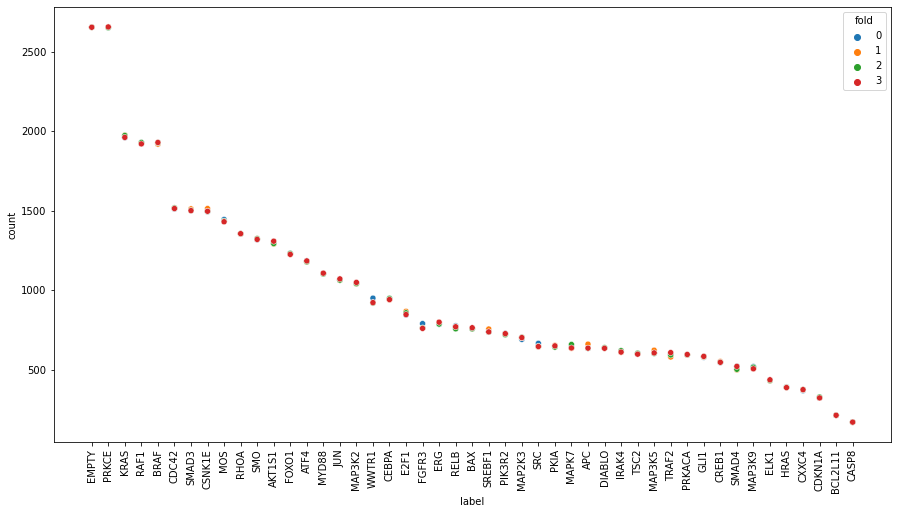

<IPython.core.display.Javascript object>

In [11]:
fig, ax = plt.subplots(figsize=[15, 8])
ax = sns.scatterplot(data=label_counts, x="label", y="count", hue="fold", ax=ax)
plt.xticks(rotation=90)
plt.show()

As mentioned earlier there is quite some variance in the relative distribution of the individual conditions. For instance we have roughly 2700 samples of MAP3K5 as the majority class in fold 2 and just 1600-1800 in the remaining folds. We are working on improving that.

---

## 4. Translational analyses

We will now use the different embeddings of the three different folds in order to model the link between the regulatory and structural space, by given a structural embedding predict the corresponding regulatory embedding. To this end, we will train a linear model for each held-out fold data. To assess the performance, we will evaluate the mapping in three distinct settings:
1. Split the data on a single-nuclei basis, i.e. samples of the same overexpression condition might end up in both the training, validation and test set.
2. Split the data on a OE condition level, i.e. samples of the a certain overexpression condition will be ending up in either of the training, validation and test set.
3. Leave-one-target out cross-validation

We will quickly setup the linear model as well as the corresponding optimizer used for that inference.

In [12]:
model = nn.Sequential(
    # nn.Linear(1024, 1024),
    # nn.PReLU(),
    # nn.BatchNorm1d(1024),
    nn.Linear(1024, 128),
)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

<IPython.core.display.Javascript object>

---

### 4.1. Baseline prediction: Nuclei split

We start of with splitting the data into a training, validation and testing set without distinguishing between OE conditions. This will serve as a baseline of how well we can translate between the two spaces within sample.

In [13]:
img_embs_fold0, node_embs_fold0 = img_node_embs_dict["fold0"]

<IPython.core.display.Javascript object>

In [14]:
data_dict = get_data_dict(
    data=img_embs_fold0,
    labels=node_embs_fold0,
    val_test_size=[0.2, 0.2],
    group_labels=None,
    batch_size=128,
)

<IPython.core.display.Javascript object>

In [15]:
fitted_model = train_model(
    model=model,
    data_dict=data_dict,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    early_stopping=20,
)

TRAIN loss: 0.0024089843958433046
VAL loss: 0.0025845410981688833
TEST loss: 0.002549888309453173


<IPython.core.display.Javascript object>

In [16]:
ks = [1, 3, 5, 10, 20, 50]
for mode in ["train", "val", "test"]:
    topk_accs = []
    topk_base_accs = []
    preds, labels = get_preds_label_dict(fitted_model, data_dict[mode])
    for k in ks:
        topk_acc, topk_base_acc = evaluate_top_k_accuracy(preds, labels, node_embs, k=k)
        topk_accs.append(topk_acc)
        topk_base_accs.append(topk_base_acc)
    print("{} top-{} accuracies: {}".format(mode.upper(), ks, np.round(topk_accs, 4)))
    print(
        "{} top-{} baseline accuracies: {}".format(
            mode.upper(), ks, np.round(topk_base_accs, 4)
        )
    )
    print(" ")

TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0847 0.1519 0.1962 0.2717 0.3681 0.5607]
TRAIN top-[1, 3, 5, 10, 20, 50] baseline accuracies: [0.0038 0.012  0.0212 0.0409 0.0782 0.1843]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0712 0.1322 0.1739 0.2421 0.3375 0.5339]
VAL top-[1, 3, 5, 10, 20, 50] baseline accuracies: [0.0044 0.012  0.0204 0.0438 0.0776 0.1824]
 
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0794 0.1396 0.1803 0.2492 0.3458 0.5359]
TEST top-[1, 3, 5, 10, 20, 50] baseline accuracies: [0.0056 0.0111 0.0247 0.0402 0.078  0.1813]
 


<IPython.core.display.Javascript object>

We see that the top-k accuracy suggest indeed a prediction that is better than naive baseline that simply predicts the k-most frequent targets for k<20 for larger k we see that the baseline outperforms the fitted model. The performances of the model on the training, validation and test set are highly comparable.

---

### 4.2. Out-of-sample prediction

In [17]:
data_dict = get_data_dict(
    data=img_embs_fold0,
    labels=node_embs_fold0,
    val_test_size=[0.2, 0.2],
    group_labels=np.array(list(node_embs_fold0.index)),
    batch_size=128,
)

<IPython.core.display.Javascript object>

In [18]:
model = nn.Sequential(
    # nn.Linear(1024, 1024),
    # nn.PReLU(),
    # nn.BatchNorm1d(1024),
    nn.Linear(1024, 128),
)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

<IPython.core.display.Javascript object>

In [19]:
fitted_model = train_model(
    model=model,
    data_dict=data_dict,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    early_stopping=20,
)

TRAIN loss: 0.002073925910697071
VAL loss: 0.0033777658469031787
TEST loss: 0.004834068350213575


<IPython.core.display.Javascript object>

In [20]:
ks = [1, 3, 5, 10, 20, 50]
for mode in ["train", "val", "test"]:
    topk_accs = []
    topk_base_accs = []
    preds, labels = get_preds_label_dict(fitted_model, data_dict[mode])
    for k in ks:
        topk_acc, topk_base_acc = evaluate_top_k_accuracy(preds, labels, node_embs, k=k)
        topk_accs.append(topk_acc)
        topk_base_accs.append(topk_base_acc)
    print("{} top-{} accuracies: {}".format(mode.upper(), ks, np.round(topk_accs, 4)))
    print(" ")

TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1165 0.1938 0.2416 0.3298 0.4473 0.6495]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0865 0.1671 0.22   0.3028 0.3893 0.5264]
 
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0672 0.1127 0.1487 0.224  0.3208 0.4723]
 


<IPython.core.display.Javascript object>

Note that for the held-out configuration the baseline accuracies are not reliable as those correspond to the most frequent classes in the corresponding data set.

---

### 4.3. Leave-one-out cross-validation

Finally, we will apply leave-one-target out crossvalidation.

In [22]:
data_dicts = get_logo_data_dicts(
    data=img_embs_fold0,
    labels=node_embs_fold0,
    val_size=0.1,
    group_labels=np.array(list(node_embs_fold0.index)),
    batch_size=128,
)

<IPython.core.display.Javascript object>

In [23]:
topk_test_accs = []
lo_labels = []
for i in tqdm(range(len(data_dicts))):
    data_dict = data_dicts[i]

    model = nn.Sequential(
        # nn.Linear(1024, 1024),
        # nn.PReLU(),
        # nn.BatchNorm1d(1024),
        nn.Linear(1024, 128),
    )
    optimizer = Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    fitted_model = train_model(
        model=model,
        data_dict=data_dict,
        optimizer=optimizer,
        criterion=criterion,
        n_epochs=100,
        early_stopping=5,
    )

    ks = [1, 3, 5, 10, 20, 50]
    for mode in ["train", "val", "test"]:
        topk_accs = []
        preds, labels = get_preds_label_dict(fitted_model, data_dict[mode])
        if mode == "test":
            lo_label = np.unique(labels)[0]
            lo_labels.append(lo_label)
            print("Left-out label: {}".format(lo_label))
        for k in ks:
            topk_acc, _ = evaluate_top_k_accuracy(preds, labels, node_embs, k=k)
            topk_accs.append(topk_acc)
        print(
            "{} top-{} accuracies: {}".format(mode.upper(), ks, np.round(topk_accs, 4))
        )
        print("---")
    topk_test_accs.append(np.array(topk_accs))

  0%|          | 0/43 [00:00<?, ?it/s]

TRAIN loss: 0.002674380767116989
VAL loss: 0.0023540252707464323
TEST loss: 0.0007934269860363853
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0893 0.1593 0.2037 0.2826 0.3788 0.5604]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.049  0.1027 0.1359 0.1924 0.2678 0.464 ]
---
Left-out label: AKT1S1


  2%|▏         | 1/43 [00:25<17:35, 25.14s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.4336 0.6698 0.7971 0.9429 0.9907 1.    ]
---
TRAIN loss: 0.002366954278554439
VAL loss: 0.005698320985887089
TEST loss: 0.005367566192496329
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.103  0.1813 0.2266 0.3072 0.4043 0.5872]
---


  5%|▍         | 2/43 [00:48<16:16, 23.83s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0236 0.0488 0.0626 0.0959 0.138  0.2857]
---
Left-out label: APC
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0016 0.0047 0.011  0.033  0.0424 0.0911]
---
TRAIN loss: 0.002558244854473387
VAL loss: 0.0026467685921980114
TEST loss: 0.0019208511538049088
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0911 0.1616 0.2069 0.2836 0.3774 0.5553]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0546 0.1119 0.1448 0.2028 0.268  0.4468]
---
Left-out label: ATF4


  7%|▋         | 3/43 [01:16<17:11, 25.78s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0135 0.0422 0.054  0.092  0.2076 0.5722]
---
TRAIN loss: 0.0023964676466645234
VAL loss: 0.005039473445020051
TEST loss: 0.002474043370251566
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0979 0.1765 0.2225 0.3026 0.3987 0.5778]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0337 0.0669 0.0944 0.1326 0.1839 0.329 ]
---
Left-out label: BAX


  9%|▉         | 4/43 [01:41<16:38, 25.61s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0831 0.1082 0.1266 0.1425 0.1741 0.2968]
---
TRAIN loss: 0.002594062267248387
VAL loss: 0.006368750876962465
TEST loss: 0.002946458609644757
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0972 0.1701 0.216  0.297  0.3994 0.5927]
---


 12%|█▏        | 5/43 [02:01<14:51, 23.45s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0309 0.0695 0.0916 0.1248 0.1696 0.2612]
---
Left-out label: BCL2L11
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.     0.     0.0698]
---
TRAIN loss: 0.0026854045472337515
VAL loss: 0.0044517353236512075
TEST loss: 0.0021468435142115495
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0944 0.1655 0.2091 0.2863 0.378  0.5592]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0535 0.0966 0.1234 0.1762 0.2398 0.4091]
---
Left-out label: BRAF


 14%|█▍        | 6/43 [02:23<14:08, 22.94s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1324 0.209  0.2507 0.3142 0.3846 0.5487]
---
TRAIN loss: 0.0022750476847769427
VAL loss: 0.005872402757689623
TEST loss: 0.002127908714856321
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1093 0.1868 0.2337 0.3137 0.4148 0.6063]
---


 16%|█▋        | 7/43 [02:46<13:52, 23.12s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0146 0.0299 0.0502 0.0921 0.1359 0.2369]
---
Left-out label: CASP8
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0117 0.0292 0.0526 0.0936 0.193  0.4854]
---
TRAIN loss: 0.0027608809431997083
VAL loss: 0.002285915519471894
TEST loss: 0.0016588938179815178
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0912 0.1637 0.2056 0.2802 0.3714 0.5501]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0525 0.1281 0.1642 0.2244 0.3137 0.5233]
---
Left-out label: CDC42


 19%|█▊        | 8/43 [03:11<13:45, 23.58s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.125  0.244  0.3142 0.3862 0.5093 0.7493]
---
TRAIN loss: 0.0023067020787500164
VAL loss: 0.006647056756844701
TEST loss: 0.026030961010191176
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1049 0.1827 0.2291 0.3094 0.4063 0.5943]
---


 21%|██        | 9/43 [03:32<12:57, 22.86s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0273 0.0513 0.0683 0.1006 0.1408 0.2475]
---
Left-out label: CDKN1A
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0. 0. 0. 0. 0. 0.]
---
TRAIN loss: 0.0024886073714616005
VAL loss: 0.004839403485070082
TEST loss: 0.0018758442997342368
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.094  0.1705 0.2189 0.2987 0.3943 0.5701]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0364 0.0778 0.101  0.151  0.2238 0.4195]
---
Left-out label: CEBPA


 23%|██▎       | 10/43 [03:55<12:35, 22.90s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0781 0.1616 0.2091 0.2883 0.4203 0.6272]
---
TRAIN loss: 0.0023058252403759154
VAL loss: 0.006968569166530587
TEST loss: 0.002878327366142046
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0924 0.1649 0.214  0.2961 0.4008 0.6001]
---


 26%|██▌       | 11/43 [04:17<12:09, 22.80s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0041 0.0121 0.019  0.0373 0.0621 0.1518]
---
Left-out label: CREB1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.     0.     0.0604]
---
TRAIN loss: 0.0023720440918198965
VAL loss: 0.006438122275057403
TEST loss: 0.003372234277684921
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1005 0.1828 0.2309 0.3125 0.4086 0.5902]
---


 28%|██▊       | 12/43 [04:39<11:39, 22.55s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0076 0.017  0.0249 0.047  0.0708 0.184 ]
---
Left-out label: DIABLO
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.0016 0.011  0.0267 0.0503 0.1682]
---
TRAIN loss: 0.002620005100130636
VAL loss: 0.005726009937350688
TEST loss: 0.004658806138841466
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0876 0.1618 0.2069 0.2878 0.3921 0.5719]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0102 0.0425 0.0609 0.0962 0.1378 0.2952]
---
Left-out label: E2F1


 30%|███       | 13/43 [05:00<11:02, 22.08s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.013  0.0402 0.0544 0.0768 0.1277 0.2589]
---
TRAIN loss: 0.0023722932449086174
VAL loss: 0.007441947707722368
TEST loss: 0.0012291621160371582
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1079 0.188  0.2338 0.3128 0.4058 0.588 ]
---


 33%|███▎      | 14/43 [05:24<10:48, 22.38s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.004  0.0105 0.0136 0.0269 0.0413 0.1353]
---
Left-out label: ELK1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0484 0.2327 0.3825 0.5276 0.7189 0.9977]
---
TRAIN loss: 0.002438719359855981
VAL loss: 0.005737341053366341
TEST loss: 0.0030782742380239115
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0919 0.1664 0.2133 0.2944 0.3913 0.5775]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0144 0.0456 0.0643 0.1095 0.1506 0.2658]
---
Left-out label: ERG


 35%|███▍      | 15/43 [05:48<10:40, 22.89s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1309 0.1639 0.1792 0.197  0.2402 0.371 ]
---
TRAIN loss: 0.0023978739812988725
VAL loss: 0.005584095693289592
TEST loss: 0.003796618453588445
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0954 0.1703 0.2173 0.3034 0.4055 0.5895]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0184 0.0447 0.0637 0.0943 0.1444 0.2748]
---
Left-out label: FGFR3


 37%|███▋      | 16/43 [06:11<10:22, 23.06s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.0013 0.0013 0.019 ]
---
TRAIN loss: 0.002605298520939129
VAL loss: 0.004910530565104094
TEST loss: 0.0011672416381392774
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0864 0.1581 0.2036 0.2824 0.3807 0.564 ]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0241 0.0538 0.0736 0.1016 0.1347 0.2867]
---
Left-out label: FOXO1


 40%|███▉      | 17/43 [06:34<10:01, 23.15s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1469 0.3295 0.4424 0.6136 0.776  0.9951]
---
TRAIN loss: 0.002468781540865531
VAL loss: 0.007103570691999728
TEST loss: 0.007860698322210596
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1065 0.1864 0.234  0.313  0.4092 0.5927]
---


 42%|████▏     | 18/43 [06:55<09:19, 22.37s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0119 0.0306 0.0402 0.0609 0.0852 0.1687]
---
Left-out label: GLI1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0. 0. 0. 0. 0. 0.]
---
TRAIN loss: 0.00231936842607036
VAL loss: 0.007431767185930584
TEST loss: 0.0015753052249531862
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0903 0.1701 0.2213 0.3085 0.4121 0.6002]
---


 44%|████▍     | 19/43 [07:16<08:46, 21.94s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0059 0.0172 0.0261 0.0411 0.061  0.1659]
---
Left-out label: HRAS
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.084  0.1832 0.2545 0.4326 0.6234 0.9186]
---
TRAIN loss: 0.0023401948735813404
VAL loss: 0.007011524257298962
TEST loss: 0.0029542513057243132
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0916 0.1645 0.2135 0.3001 0.4094 0.6021]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.003  0.0108 0.0172 0.0395 0.0683 0.1788]
---
Left-out label: IRAK4


 47%|████▋     | 20/43 [07:38<08:25, 21.99s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0016 0.0049 0.0049 0.0114 0.0359 0.1876]
---
TRAIN loss: 0.0023341860253368414
VAL loss: 0.005902709707161489
TEST loss: 0.001369518948249743
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1061 0.1867 0.2348 0.315  0.4094 0.5899]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0086 0.0177 0.022  0.0374 0.0629 0.2006]
---
Left-out label: JUN


 49%|████▉     | 21/43 [08:02<08:20, 22.73s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1823 0.3195 0.4276 0.5564 0.687  0.8487]
---
TRAIN loss: 0.0026435024016184757
VAL loss: 0.005901496654937836
TEST loss: 0.0014846330589367723
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1017 0.1779 0.2223 0.304  0.4059 0.588 ]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0019 0.0075 0.0118 0.0309 0.0688 0.189 ]
---
Left-out label: KRAS


 51%|█████     | 22/43 [08:22<07:40, 21.92s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.048  0.1515 0.2418 0.4602 0.7276 0.9801]
---
TRAIN loss: 0.002311602659623531
VAL loss: 0.006575467829893284
TEST loss: 0.0012174568850966978
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0967 0.1729 0.2198 0.3032 0.4048 0.5928]
---


 53%|█████▎    | 23/43 [08:46<07:26, 22.31s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0078 0.0245 0.0331 0.0562 0.085  0.2046]
---
Left-out label: MAP2K3
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.078  0.1951 0.2861 0.5159 0.7587 0.9971]
---
TRAIN loss: 0.0024043702404391736
VAL loss: 0.005742037074664684
TEST loss: 0.0011334864175784709
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1031 0.1805 0.2316 0.3137 0.4131 0.5924]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0024 0.0108 0.0196 0.0395 0.068  0.1775]
---
Left-out label: MAP3K2


 56%|█████▌    | 24/43 [09:06<06:54, 21.80s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1467 0.2627 0.4036 0.6127 0.8015 0.9923]
---
TRAIN loss: 0.0022659021725681652
VAL loss: 0.006634901039819222
TEST loss: 0.0007990523155112535
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0982 0.1781 0.2287 0.313  0.4121 0.5955]
---


 58%|█████▊    | 25/43 [09:31<06:46, 22.59s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0067 0.0199 0.028  0.0489 0.0731 0.1664]
---
Left-out label: MAP3K5
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.3808 0.6921 0.803  0.9222 0.995  1.    ]
---
TRAIN loss: 0.002290630900428129
VAL loss: 0.0073243289018707445
TEST loss: 0.003243535278443669
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.087  0.1654 0.2168 0.3012 0.4128 0.6036]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0086 0.0183 0.0272 0.0462 0.0745 0.1573]
---
Left-out label: MAP3K9


 60%|██████    | 26/43 [09:54<06:26, 22.75s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0902 0.1132 0.1228 0.1363 0.1689 0.2514]
---
TRAIN loss: 0.0023623575748987612
VAL loss: 0.006421216490094253
TEST loss: 0.0025078715900374742
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.096  0.1723 0.219  0.3022 0.4068 0.5959]
---


 63%|██████▎   | 27/43 [10:19<06:13, 23.35s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0091 0.0226 0.0323 0.0559 0.0858 0.2073]
---
Left-out label: MAPK7
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0359 0.0905 0.1092 0.156  0.2309 0.429 ]
---
TRAIN loss: 0.0025123400389721394
VAL loss: 0.005916928845232603
TEST loss: 0.0029980669277247744
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1027 0.1805 0.2288 0.3093 0.4095 0.595 ]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0013 0.0067 0.0121 0.0231 0.0444 0.1823]
---
Left-out label: MYD88


 65%|██████▌   | 28/43 [10:40<05:43, 22.88s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.0045 0.0109 0.067 ]
---
TRAIN loss: 0.00230036279469775
VAL loss: 0.006696729636449356
TEST loss: 0.0012343637685167548
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1002 0.1815 0.2309 0.3154 0.4189 0.6021]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0035 0.0121 0.0177 0.0333 0.0583 0.1664]
---
Left-out label: PIK3R2


 67%|██████▋   | 29/43 [11:04<05:22, 23.02s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0604 0.1893 0.2716 0.4074 0.6351 0.9451]
---
TRAIN loss: 0.0023166733866096852
VAL loss: 0.00680688770616121
TEST loss: 0.005853036929561053
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1048 0.1862 0.2357 0.3167 0.4163 0.5981]
---


 70%|██████▉   | 30/43 [11:27<05:00, 23.08s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0056 0.0194 0.0285 0.0468 0.0713 0.1683]
---
Left-out label: PKIA
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.0046 0.0046 0.0077 0.0216]
---
TRAIN loss: 0.002480516730353109
VAL loss: 0.00717347783619264
TEST loss: 0.004961157178424725
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1039 0.1875 0.2388 0.3263 0.4264 0.6072]
---


 72%|███████▏  | 31/43 [11:48<04:29, 22.45s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0046 0.0177 0.0253 0.0446 0.0688 0.1503]
---
Left-out label: PRKACA
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.     0.0034 0.0067]
---
TRAIN loss: 0.002485779144427473
VAL loss: 0.006006306190127329
TEST loss: 0.0014956258137276337
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0996 0.1833 0.2363 0.3208 0.4195 0.5996]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0016 0.0089 0.0132 0.0229 0.0473 0.1928]
---
Left-out label: PRKCE


 74%|███████▍  | 32/43 [12:09<04:01, 21.97s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0882 0.1723 0.2262 0.3428 0.5437 0.8643]
---
TRAIN loss: 0.0025072070706432786
VAL loss: 0.005677779852486515
TEST loss: 0.003215924735548445
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0996 0.1786 0.2253 0.3072 0.4072 0.5872]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0065 0.0169 0.0274 0.0524 0.0957 0.2248]
---
Left-out label: RAF1


 77%|███████▋  | 33/43 [12:31<03:41, 22.15s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0316 0.0886 0.1026 0.1379 0.1928 0.3281]
---
TRAIN loss: 0.002348647464975555
VAL loss: 0.006489596700255238
TEST loss: 0.0012305570925745342
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1039 0.1836 0.2352 0.3155 0.4167 0.5988]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0054 0.0194 0.0264 0.0428 0.0683 0.1831]
---
Left-out label: RELB


 79%|███████▉  | 34/43 [12:53<03:17, 21.99s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.2265 0.3912 0.444  0.5586 0.7143 0.9356]
---
TRAIN loss: 0.0024481971866511278
VAL loss: 0.005395025628131573
TEST loss: 0.0017611201630898397
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1089 0.184  0.2298 0.3105 0.4108 0.5909]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0043 0.0121 0.0169 0.0285 0.0516 0.1581]
---
Left-out label: RHOA


 81%|████████▏ | 35/43 [13:17<03:01, 22.68s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0044 0.0118 0.0229 0.0827 0.1963 0.6443]
---
TRAIN loss: 0.0025740779234137996
VAL loss: 0.005759360969927323
TEST loss: 0.00370069091794141
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0976 0.1698 0.2145 0.2995 0.4032 0.5939]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0091 0.0202 0.0285 0.0497 0.0836 0.1963]
---
Left-out label: SMAD3


 84%|████████▎ | 36/43 [13:39<02:36, 22.37s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.002  0.0113 0.0206 0.0372 0.0624 0.1427]
---
TRAIN loss: 0.002341243760317735
VAL loss: 0.007408304604443512
TEST loss: 0.002910389340129392
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0955 0.1695 0.218  0.3059 0.4129 0.6083]
---


 86%|████████▌ | 37/43 [14:01<02:13, 22.32s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0051 0.0132 0.0194 0.0317 0.053  0.1301]
---
Left-out label: SMAD4
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.     0.     0.0728]
---
TRAIN loss: 0.0025074108671825166
VAL loss: 0.006176871728868537
TEST loss: 0.008213562279773016
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1    0.1743 0.2209 0.3027 0.3991 0.5781]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0014 0.0079 0.0137 0.025  0.0414 0.1523]
---
Left-out label: SMO


 88%|████████▊ | 38/43 [14:25<01:53, 22.63s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.0015 0.003  0.0038 0.0061 0.0197]
---
TRAIN loss: 0.002527521524537772
VAL loss: 0.006204531392915089
TEST loss: 0.0039213992385794105
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.092  0.1695 0.2196 0.301  0.4001 0.58  ]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0092 0.026  0.0376 0.0739 0.1099 0.2324]
---
Left-out label: SRC


 91%|█████████ | 39/43 [14:46<01:29, 22.44s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.003  0.0045 0.006  0.009  0.063 ]
---
TRAIN loss: 0.0024291554470364913
VAL loss: 0.006225979469096942
TEST loss: 0.0015250702513979195
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0859 0.1615 0.2082 0.2909 0.3933 0.5788]
---


 93%|█████████▎| 40/43 [15:10<01:08, 22.90s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0092 0.025  0.0352 0.0602 0.089  0.2108]
---
Left-out label: SREBF1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0528 0.1353 0.1759 0.3004 0.4777 0.8268]
---
TRAIN loss: 0.0025541074267747973
VAL loss: 0.006430732090603675
TEST loss: 0.0020410363124730145
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0806 0.1538 0.1996 0.2822 0.3871 0.5817]
---


 95%|█████████▌| 41/43 [15:34<00:46, 23.12s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0034 0.013  0.0168 0.0397 0.0743 0.1899]
---
Left-out label: TRAF2
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.005  0.0117 0.0234 0.0568 0.4975]
---
TRAIN loss: 0.002483488055925245
VAL loss: 0.006233134121786418
TEST loss: 0.0018177206607979555
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0985 0.1733 0.2187 0.2964 0.3915 0.5716]
---


 98%|█████████▊| 42/43 [15:58<00:23, 23.25s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0062 0.0171 0.0284 0.0507 0.0815 0.2245]
---
Left-out label: TSC2
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0298 0.0828 0.1374 0.2434 0.3874 0.7997]
---
TRAIN loss: 0.002664277592595752
VAL loss: 0.007003603249119179
TEST loss: 0.004373046950966935
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.0912 0.1643 0.2102 0.289  0.3908 0.5823]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.0058 0.0109 0.0268 0.0633 0.1837]
---
Left-out label: WWTR1


100%|██████████| 43/43 [16:19<00:00, 22.78s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.     0.     0.0042]
---


<IPython.core.display.Javascript object>

In [24]:
logo_results = dict(zip(lo_labels, topk_test_accs))
logo_results

{'AKT1S1': array([0.43364198, 0.66975309, 0.7970679 , 0.94290123, 0.99074074,
        1.        ]),
 'APC': array([0.00156986, 0.00470958, 0.01098901, 0.03296703, 0.04238619,
        0.09105181]),
 'ATF4': array([0.01350211, 0.04219409, 0.05400844, 0.09198312, 0.20759494,
        0.5721519 ]),
 'BAX': array([0.08311346, 0.10817942, 0.12664908, 0.14248021, 0.17414248,
        0.29683377]),
 'BCL2L11': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.06976744]),
 'BRAF': array([0.1323606 , 0.208963  , 0.25065138, 0.31422616, 0.3845753 ,
        0.54872329]),
 'CASP8': array([0.01169591, 0.02923977, 0.05263158, 0.09356725, 0.19298246,
        0.48538012]),
 'CDC42': array([0.125     , 0.24404762, 0.31415344, 0.38624339, 0.50925926,
        0.74933862]),
 'CDKN1A': array([0., 0., 0., 0., 0., 0.]),
 'CEBPA': array([0.0781415 , 0.16156283, 0.20908131, 0.28827878, 0.42027455,
        0.62724393]),
 'CREB1': array([0.        , 0.        , 0.        , 0.        , 0. 

<IPython.core.display.Javascript object>

In [25]:
logo_results_df = pd.DataFrame(logo_results)
logo_results_df = logo_results_df.transpose()
logo_results_df.columns = ["top1", "top3", "top5", "top10", "top20", "top50"]
logo_results_df.head()

,top1,top3,top5,top10,top20,top50
AKT1S1,0.433642,0.669753,0.797068,0.942901,0.990741,1.000000
APC,0.001570,0.004710,0.010989,0.032967,0.042386,0.091052
ATF4,0.013502,0.042194,0.054008,0.091983,0.207595,0.572152
BAX,0.083113,0.108179,0.126649,0.142480,0.174142,0.296834
BCL2L11,0.000000,0.000000,0.000000,0.000000,0.000000,0.069767


<IPython.core.display.Javascript object>

In [27]:
logo_results_df.mean(axis=0)

top1     0.064219
top3     0.124223
top5     0.161939
top10    0.225392
top20    0.306248
top50    0.468718
dtype: float64

<IPython.core.display.Javascript object>

In [28]:
logo_results_df.std(axis=0)

top1     0.096422
top3     0.164575
top5     0.202263
top10    0.257776
top20    0.315939
top50    0.381914
dtype: float64

<IPython.core.display.Javascript object>

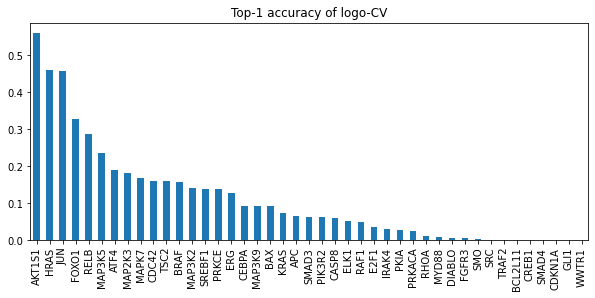

<IPython.core.display.Javascript object>

In [50]:
ax = logo_results_df.sort_values("top1", ascending=False).top1.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-1 accuracy of logo-CV")
plt.show()

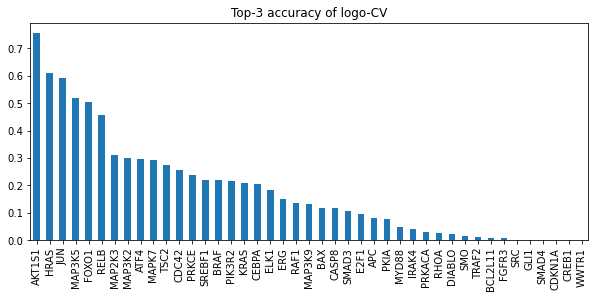

<IPython.core.display.Javascript object>

In [51]:
ax = logo_results_df.sort_values("top3", ascending=False).top3.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-3 accuracy of logo-CV")
plt.show()

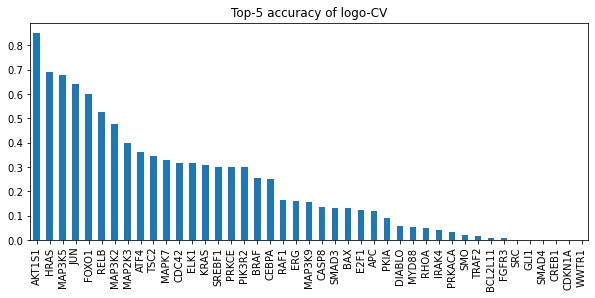

<IPython.core.display.Javascript object>

In [52]:
ax = logo_results_df.sort_values("top5", ascending=False).top5.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-5 accuracy of logo-CV")
plt.show()

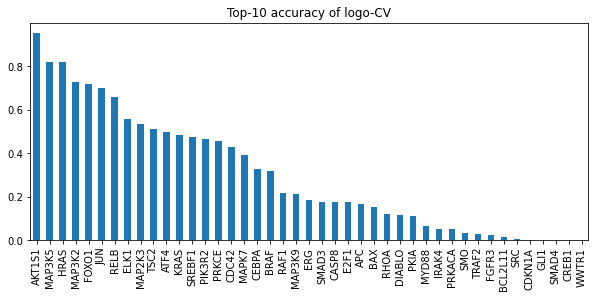

<IPython.core.display.Javascript object>

In [53]:
ax = logo_results_df.sort_values("top10", ascending=False).top10.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-10 accuracy of logo-CV")
plt.show()

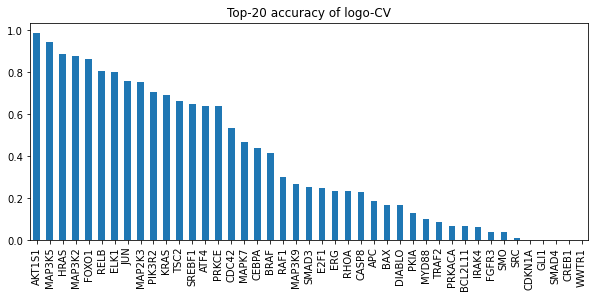

<IPython.core.display.Javascript object>

In [54]:
ax = logo_results_df.sort_values("top20", ascending=False).top20.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-20 accuracy of logo-CV")
plt.show()

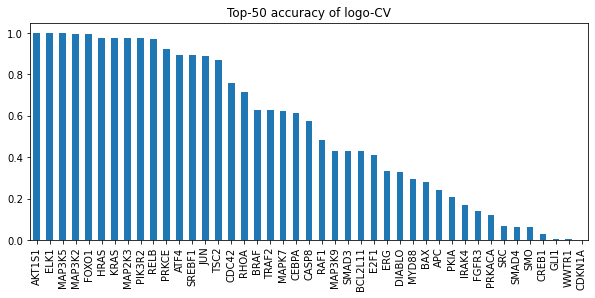

<IPython.core.display.Javascript object>

In [55]:
ax = logo_results_df.sort_values("top50", ascending=False).top50.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-50 accuracy of logo-CV")
plt.show()